In [1]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
device = torch.device("cuda")

In [3]:
nsmc_train_data=pd.read_table("data/nsmc/ratings_train.txt")
nsmc_test_data=pd.read_table("data/nsmc/ratings_test.txt")
kaggle_data=pd.read_table("data/kaggle/kr3.tsv")

<AxesSubplot:>

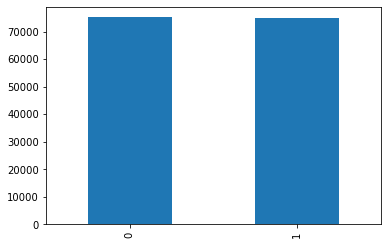

In [4]:
#네이버 영화 평점 데이터 라벨 분포(0:부정, 1:긍정)
nsmc_train_data['label'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

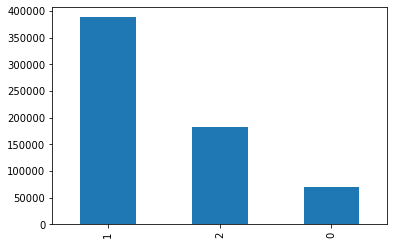

In [5]:
#kaggle 레스토랑 평점 데이터 라벨 분포(0:부정,1:긍정,2:모호함)
kaggle_data['Rating'].value_counts().plot(kind = 'bar')

In [6]:
#nsmc 데이터 + kaggle 데이터
total_data=pd.DataFrame({"document":nsmc_train_data["document"],
                       "label":nsmc_train_data["label"]})
total_data_2=pd.DataFrame({"document":kaggle_data["Review"],
                       "label":kaggle_data["Rating"]})
total_data=total_data.append(total_data_2,ignore_index=True)
total_data

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
791757,"요즘, 핫하게,,, 떠오르고 있는 중국집. , 맥주의 여 파루 속이 안 좋지만 와봄...",2
791758,원래 글 안 쓰는데 이거는 정말 다른 분들 위해서 써야 할 것 같네요 방금 포장 주...,0
791759,"우리 팀 단골집, 술 먹고 다음 날 가면 푸짐하게 배불리 해장할 수 있는 곳, 주말...",1
791760,"원래는 평택에 있었는데, 연남동에도 최근에 생겨서 방문했는데.. 진짜 줄이 어마어마...",2


<AxesSubplot:>

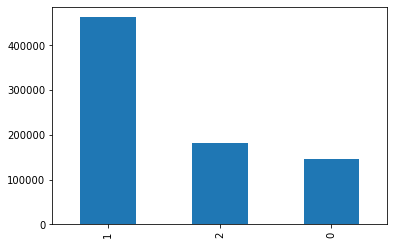

In [7]:
total_data['label'].value_counts().plot(kind = 'bar')

In [8]:
#데이터 전처리, 중복과 null값 제거
#train
total_data.drop_duplicates(subset=['document'], inplace=True)
total_data=total_data.dropna(how='any')
#test
nsmc_test_data.drop_duplicates(subset=['document'], inplace=True)
nsmc_test_data=nsmc_test_data.dropna(how='any')

In [9]:
#데이터 전처리, [CLS](문장 시작 토큰)와 [SEP](문장 종료 토큰)붙이기
#train data
document_train_data=["[CLS]"+str(s)+" [SEP]" for s in total_data.document]

#test data
sentences=nsmc_test_data['document']
document_test_data=["[CLS]"+str(s)+" [SEP]" for s in sentences]
labels=nsmc_test_data["label"].values

In [10]:
#토크나이징
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
#train data
tokenized_train_texts = [tokenizer.tokenize(s) for s in document_train_data]
#test data
tokenized_test_texts = [tokenizer.tokenize(s) for s in document_test_data]

print(tokenized_train_texts[0])
print(tokenized_test_texts[0])

['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]']
['[CLS]', '굳', '[UNK]', '[SEP]']


In [11]:
#패딩
MAX_LEN = 128
#train data
input_train_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train_texts]
input_train_ids = pad_sequences(input_train_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
#test data
input_test_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test_texts]
input_test_ids = pad_sequences(input_test_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

input_train_ids.shape

(785738, 128)

In [12]:
#어텐션 마스크
attention_train_masks = []
attention_test_masks=[]

for seq in input_train_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_train_masks.append(seq_mask)
    
for seq in input_test_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_test_masks.append(seq_mask)

In [13]:
#train용 학습 데이터 전처리
#train - validation set 분리
train_inputs, validation_inputs, train_labels, validation_labels =\
train_test_split(input_train_ids, total_data['label'].values, random_state=42, test_size=0.1)#input과 mask를 섞이지 않게 random_state seed를 고정

train_masks, validation_masks, _, _ = train_test_split(attention_train_masks, 
                                                       input_train_ids,
                                                       random_state=42, 
                                                       test_size=0.1)

#train dataset sampling
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

#test dataset sampling
test_inputs = torch.tensor(input_test_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_test_masks)


In [14]:
#batch & dataloader setting

BATCH_SIZE = 32
#train
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
#validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)
#test
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [15]:
print(train_inputs.shape)
print(train_masks.shape)
print(train_labels.shape)

torch.Size([707164, 128])
torch.Size([707164, 128])
torch.Size([707164])


In [16]:
#모델 설정(BERT)
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [17]:
#옵티마이저 설정(AdamW)
optimizer=AdamW(model.parameters(),
               lr=2e-5,
               eps=1e-8
               )

epochs=4

total_steps=len(train_dataloader)*epochs

scheduler=get_linear_schedule_with_warmup(optimizer,
                                         num_warmup_steps=0,
                                         num_training_steps=total_steps)

C:\Users\DESKTOP\anaconda3\envs\a2\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [18]:
 # 정확도 계산
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [19]:
for step, batch in enumerate(train_dataloader):
    for t in batch:
        print(t.shape)


torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([32, 128])
to

In [20]:
# Basline Model of BERT(data: nsmc+kaggle)
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 train 반복
for epoch_i in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    for step, batch in enumerate(train_dataloader):
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device).long() for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    #Validation

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        
        batch = tuple(t.to(device).long() for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        #정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")



======== Epoch 1 / 4 ========
Training...
  Batch   500  of  22,099.    Elapsed: 0:03:57.
  Batch 1,000  of  22,099.    Elapsed: 0:07:52.
  Batch 1,500  of  22,099.    Elapsed: 0:11:48.
  Batch 2,000  of  22,099.    Elapsed: 0:15:41.
  Batch 2,500  of  22,099.    Elapsed: 0:19:34.
  Batch 3,000  of  22,099.    Elapsed: 0:23:28.
  Batch 3,500  of  22,099.    Elapsed: 0:27:20.
  Batch 4,000  of  22,099.    Elapsed: 0:31:11.
  Batch 4,500  of  22,099.    Elapsed: 0:35:02.
  Batch 5,000  of  22,099.    Elapsed: 0:38:52.
  Batch 5,500  of  22,099.    Elapsed: 0:42:44.
  Batch 6,000  of  22,099.    Elapsed: 0:46:36.
  Batch 6,500  of  22,099.    Elapsed: 0:50:32.
  Batch 7,000  of  22,099.    Elapsed: 0:54:30.
  Batch 7,500  of  22,099.    Elapsed: 0:58:24.
  Batch 8,000  of  22,099.    Elapsed: 1:02:19.
  Batch 8,500  of  22,099.    Elapsed: 1:06:12.
  Batch 9,000  of  22,099.    Elapsed: 1:10:04.
  Batch 9,500  of  22,099.    Elapsed: 1:13:56.
  Batch 10,000  of  22,099.    Elapsed: 1:17:

  Batch 13,500  of  22,099.    Elapsed: 1:44:35.
  Batch 14,000  of  22,099.    Elapsed: 1:48:27.
  Batch 14,500  of  22,099.    Elapsed: 1:52:20.
  Batch 15,000  of  22,099.    Elapsed: 1:56:11.
  Batch 15,500  of  22,099.    Elapsed: 2:00:03.
  Batch 16,000  of  22,099.    Elapsed: 2:03:54.
  Batch 16,500  of  22,099.    Elapsed: 2:07:46.
  Batch 17,000  of  22,099.    Elapsed: 2:11:38.
  Batch 17,500  of  22,099.    Elapsed: 2:15:29.
  Batch 18,000  of  22,099.    Elapsed: 2:19:21.
  Batch 18,500  of  22,099.    Elapsed: 2:23:13.
  Batch 19,000  of  22,099.    Elapsed: 2:27:04.
  Batch 19,500  of  22,099.    Elapsed: 2:30:59.
  Batch 20,000  of  22,099.    Elapsed: 2:34:55.
  Batch 20,500  of  22,099.    Elapsed: 2:38:51.
  Batch 21,000  of  22,099.    Elapsed: 2:42:44.
  Batch 21,500  of  22,099.    Elapsed: 2:46:36.
  Batch 22,000  of  22,099.    Elapsed: 2:50:29.

  Average training loss: 0.38
  Training epcoh took: 2:51:15

Running Validation...
  Accuracy: 0.79
  Validation too

In [22]:
#test
#시작 시간 설정
t0 = time.time()

model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(test_dataloader):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    batch = tuple(t.to(device).long() for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():     
        # Forward
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of  1,537.    Elapsed: 0:00:11.
  Batch   200  of  1,537.    Elapsed: 0:00:22.
  Batch   300  of  1,537.    Elapsed: 0:00:33.
  Batch   400  of  1,537.    Elapsed: 0:00:44.
  Batch   500  of  1,537.    Elapsed: 0:00:56.
  Batch   600  of  1,537.    Elapsed: 0:01:07.
  Batch   700  of  1,537.    Elapsed: 0:01:18.
  Batch   800  of  1,537.    Elapsed: 0:01:29.
  Batch   900  of  1,537.    Elapsed: 0:01:40.
  Batch 1,000  of  1,537.    Elapsed: 0:01:51.
  Batch 1,100  of  1,537.    Elapsed: 0:02:02.
  Batch 1,200  of  1,537.    Elapsed: 0:02:14.
  Batch 1,300  of  1,537.    Elapsed: 0:02:24.
  Batch 1,400  of  1,537.    Elapsed: 0:02:35.
  Batch 1,500  of  1,537.    Elapsed: 0:02:46.

Accuracy: 0.87
Test took: 0:02:50
